## Wind Data Retrieval

Original Author: Felix Schwock  
Modified By: Matthew Munson

In [1]:
import numpy as np
import json
from matplotlib import pyplot as plt
from obspy import read,Stream, Trace
from obspy.core import UTCDateTime
import math as M
from matplotlib import mlab
from matplotlib.colors import Normalize
import requests
from lxml import html
from scipy import signal
import matplotlib.colors as colors
import datetime
from scipy import signal
import requests
import urllib
import datetime
import time as tm
import pandas as pd
import function_lib as lib
import matplotlib.dates as mdates
import os

import pickle

In [2]:
def smoothen_data2_revised(L, data, win):
    if win == "rect":
        ma_filter = np.ones(L) / L
    elif win == "hann":
        if L % 2 == 0: L = L + 1
        ma_filter = signal.hann(L, True)
        ma_filter = ma_filter / np.sum(ma_filter)
    
    data_smooth = np.convolve(data, ma_filter, 'same')
        
    return data_smooth

## Given a datetime, find the corresponding index in the wind speed array

Used a binary search to speed things up

In [65]:
def datetime_to_index(time_array, target_time):
    
    low = 0
    high = len(time_array) - 1
    mid = 0
    
    while low <= high:
        
        mid = (high + low) // 2
        
        if(time_array[mid] > target_time):
            high = mid - 1
        elif(time_array[mid] < target_time):
            low = mid + 1
        else:
            return mid
    
    return mid

## Oregon Offshore

### Network Retrieval

In [3]:
## get URLs for mooring data
urls_offshore = lib.web_crawler_mooring('2015-05-01T00:00:00.000Z', '2020-02-20T12:00:00.000Z', location='offshore')

telemetered
{'requestUUID': '82216040-b197-4f37-a3d4-ef09e6e1d902', 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html', 'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html', 'https://opendap.oceanobservatories.org/async_results/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument'], 'sizeCalculation': 177918760, 'timeCalculation': 60, 'numberOfSubJobs': 64}
request completed


In [4]:
# get mooring data
print(urls_offshore)
data_offshore = lib.get_mooring_data(urls_offshore)

['https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150501T000049-20150517T235939.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150518T000012-20150614T235901.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150615T000005-20150712T235929.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T222402592Z-CE04OSSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/dep

### File Retrieval

In [59]:
# Get Mooring Data from pickle file
path = "pickle/dataOffshore.pickle"
data_offshore = pickle.load( open( path, "rb" ) )


### Processing / Visualization

In [60]:
# convert seconds to datetime
time_offshore = data_offshore.time
time_offshore = time_offshore.apply(lib.ntp_seconds_to_datetime)

# get wind data
wind_mag_offshore = np.sqrt((data_offshore.eastward_wind_velocity)**2 + (data_offshore.northward_wind_velocity)**2)
wind_angle_offshore = np.arctan2(data_offshore.northward_wind_velocity, data_offshore.eastward_wind_velocity)

Text(0, 0.5, 'wind speed [m/s]')

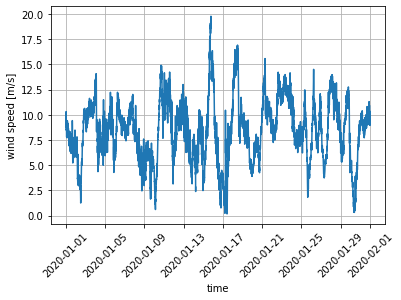

In [62]:
# define start and end dates
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2020,2,1)

# define start and end indices
start_index = datetime_to_index(time_offshore, start_date)
end_index = datetime_to_index(time_offshore, end_date)

# smoothen wind data
wind_vec_offshore = wind_mag_offshore * np.exp(1j * wind_angle_offshore)
wind_vec_smooth_offshore = smoothen_data2_revised(21, wind_vec_offshore, 'hann')
wind_mag_smooth_offshore = abs(wind_vec_smooth_offshore) # wind speed (smoothed)
wind_angle_smooth_offshore = np.angle(wind_vec_smooth_offshore) # wind angle rel. to eastward direction (smoothed)

# plot 200 samples (i.e. 200 min) of smoothed wind speed
plt.plot(time_offshore[start_index:end_index], wind_mag_smooth_offshore[start_index:end_index])
plt.grid()
plt.xlabel('time')
plt.xticks(rotation = 45)
plt.ylabel('wind speed [m/s]')

### Write Data to Pickle

In [58]:
pickle.dump( data_offshore, open( "dataOffshore.pickle", "wb" ) )

## Oregon Shelf

### Network Retrieval

In [55]:
## get URLs for mooring data
urls_shelf = lib.web_crawler_mooring('2015-05-01T00:00:00.000Z', '2020-02-20T12:00:00.000Z', location='shelf')

telemetered
{'requestUUID': 'ca26f845-e33d-4e2c-a574-83c9bf31bb18', 'outputURL': 'https://opendap.oceanobservatories.org/thredds/catalog/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html', 'allURLs': ['https://opendap.oceanobservatories.org/thredds/catalog/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/catalog.html', 'https://opendap.oceanobservatories.org/async_results/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument'], 'sizeCalculation': 218955227, 'timeCalculation': 60, 'numberOfSubJobs': 64}
request completed


In [63]:
# get mooring data
print(urls_shelf)
data_shelf = lib.get_mooring_data(urls_shelf)

['https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150501T000031-20150517T235924.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150518T000028-20150614T235917.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/deployment0001_CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument_20150615T000021-20150712T235929.csv', 'https://opendap.oceanobservatories.org/thredds/fileServer/ooi/fschwock@uw.edu/20210424T233924556Z-CE02SHSM-SBD11-06-METBKA000-telemetered-metbk_a_dcl_instrument/dep

### File Retrieval

In [73]:
# Get Mooring Data from pickle file
path = "pickle/dataShelf.pickle"
data_shelf = pickle.load( open( path, "rb" ) )


### Data Processing / Retrieval

In [66]:
# convert seconds to datetime
time_shelf = data_shelf.time
time_shelf = time_shelf.apply(lib.ntp_seconds_to_datetime)

# get wind data
wind_mag_shelf = np.sqrt((data_shelf.eastward_wind_velocity)**2 + (data_shelf.northward_wind_velocity)**2)
wind_angle_shelf = np.arctan2(data_shelf.northward_wind_velocity, data_shelf.eastward_wind_velocity)

Text(0, 0.5, 'wind speed [m/s]')

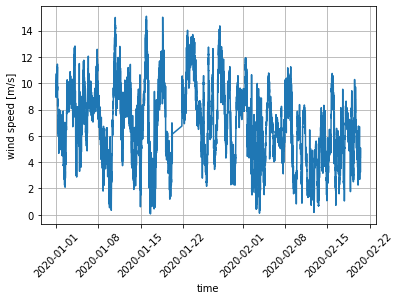

In [84]:
# define start and end dates
start_date = datetime.datetime(2020,1,1)
end_date = datetime.datetime(2021,1,1)

# define start and end indices
start_index = datetime_to_index(time_shelf, start_date)
end_index = datetime_to_index(time_shelf, end_date)

# smoothen wind data
wind_vec_shelf = wind_mag_shelf * np.exp(1j * wind_angle_shelf)
wind_vec_smooth_shelf = smoothen_data2_revised(21, wind_vec_shelf, 'hann')
wind_mag_smooth_shelf = abs(wind_vec_smooth_shelf) # wind speed (smoothed)
wind_angle_smooth_shelf = np.angle(wind_vec_smooth_shelf) # wind angle rel. to eastward direction (smoothed)

# plot 200 samples (i.e. 200 min) of smoothed wind speed
plt.plot(time_shelf[start_index:end_index], wind_mag_smooth_shelf[start_index:end_index])
plt.grid()
plt.xlabel('time')
plt.xticks(rotation = 45)
plt.ylabel('wind speed [m/s]')

### Write to Pickle File

In [72]:
pickle.dump( data_shelf, open( "dataShelf.pickle", "wb" ) )